In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.ioff()
figure(figsize=(10, 8), dpi=300)

<Figure size 3000x2400 with 0 Axes>

<Figure size 3000x2400 with 0 Axes>

In [2]:
job_arg = 8
# uncomment lines below to use CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
job_arg = 'cuda'

# disable lines below to enable interactive plots
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib')
mne.viz.set_browser_backend('matplotlib')

Using matplotlib as 2D backend.


In [18]:
# read mne-python format
raw = mne.io.read_raw_fif('../data_nn_temp/grasp_a_5_raw.fif')
#raw_a = mne.io.read_raw_fif('../data/OBCI_16_raw.fif')
#raw = mne.io.concatenate_raws([raw_l, raw_a])
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)
raw.load_data()
raw.pick_types(emg=True, eeg=True, stim=True, exclude=[])


Opening raw data file ../data_nn_temp/grasp_a_5_raw.fif...
Isotrak not found
    Range : 0 ... 960089 =      0.000 ...   960.089 secs
Ready.
Reading 0 ... 960089  =      0.000 ...   960.089 secs...


<Raw | grasp_a_5_raw.fif, 17 x 960090 (960.1 s), ~124.6 MB, data loaded>

Opening raw-browser...


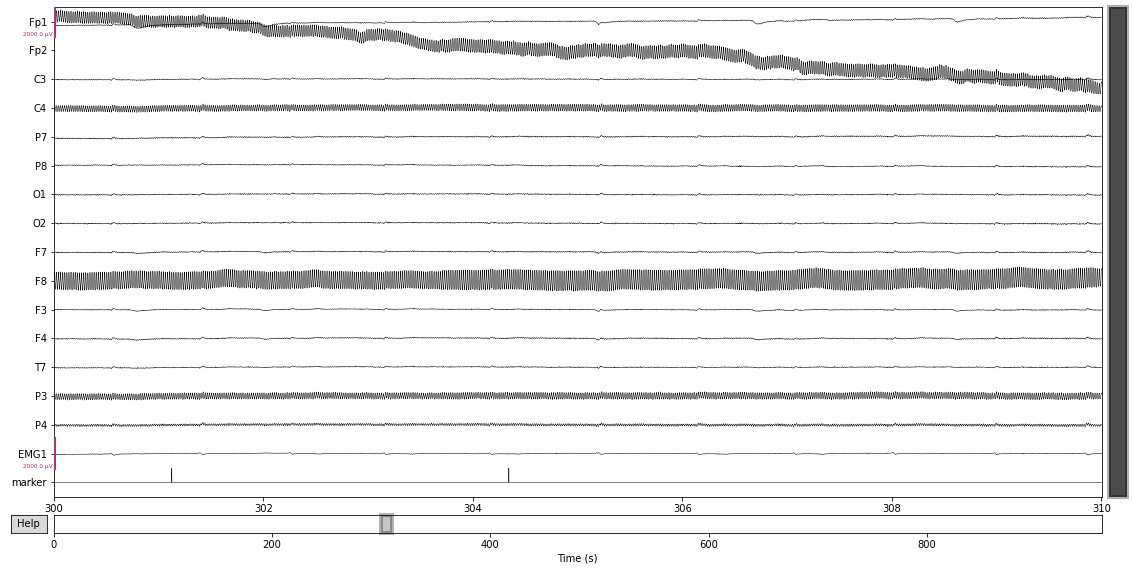

In [4]:

p = raw.plot(start = 300, duration = 10, scalings = dict(eeg = 10e-4), theme = 'dark')
# plt = raw.plot_psd(fmax=60.)
# plt = raw.plot_psd(fmax=60., average=True)
# plt = raw.plot_psd(fmin=90., fmax=500.0)
# plt = raw.plot_psd(fmin=90., fmax=500., average=True)

In [5]:
print(mne.get_config(key=''))

('MNE_3D_OPTION_ANTIALIAS', 'MNE_3D_OPTION_DEPTH_PEELING', 'MNE_3D_OPTION_SMOOTH_SHADING', 'MNE_3D_OPTION_THEME', 'MNE_BROWSE_RAW_SIZE', 'MNE_BROWSER_BACKEND', 'MNE_BROWSER_PRECOMPUTE', 'MNE_BROWSER_THEME', 'MNE_BROWSER_USE_OPENGL', 'MNE_CACHE_DIR', 'MNE_COREG_ADVANCED_RENDERING', 'MNE_COREG_COPY_ANNOT', 'MNE_COREG_GUESS_MRI_SUBJECT', 'MNE_COREG_HEAD_HIGH_RES', 'MNE_COREG_HEAD_OPACITY', 'MNE_COREG_HEAD_INSIDE', 'MNE_COREG_INTERACTION', 'MNE_COREG_MARK_INSIDE', 'MNE_COREG_PREPARE_BEM', 'MNE_COREG_ORIENT_TO_SURFACE', 'MNE_COREG_SCALE_LABELS', 'MNE_COREG_SCALE_BY_DISTANCE', 'MNE_COREG_SCENE_SCALE', 'MNE_COREG_WINDOW_HEIGHT', 'MNE_COREG_WINDOW_WIDTH', 'MNE_COREG_SUBJECTS_DIR', 'MNE_CUDA_DEVICE', 'MNE_CUDA_IGNORE_PRECISION', 'MNE_DATA', 'MNE_DATASETS_BRAINSTORM_PATH', 'MNE_DATASETS_EEGBCI_PATH', 'MNE_DATASETS_EPILEPSY_ECOG_PATH', 'MNE_DATASETS_HF_SEF_PATH', 'MNE_DATASETS_MEGSIM_PATH', 'MNE_DATASETS_MISC_PATH', 'MNE_DATASETS_MTRF_PATH', 'MNE_DATASETS_SAMPLE_PATH', 'MNE_DATASETS_SOMATO_PATH',

before doing the other method let's try a different way to detect / filter bad stuff

In [19]:

# filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],
#                                          l_freq=8, h_freq=32)

# fig = mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(0.1, 50), show = False)
# fig.set_figheight(4)
# fig.set_figwidth(4)
# fig.set_dpi(300)
# fig.show()

raw.filter(l_freq=8, h_freq=32)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 1651 samples (1.651 sec)



<Raw | grasp_a_5_raw.fif, 17 x 960090 (960.1 s), ~124.6 MB, data loaded>

In [20]:
event_ids = {
    'left': ord('l'),
    'right': ord('r'),
    'neutral': ord('n'),
    'fixation': ord('f'),
    'ready': ord('k'),
}

events = mne.find_events(raw)
reject = dict(eeg=150e-6)
epochs = mne.Epochs(raw, events, event_id=event_ids, preload=True, reject=reject, tmin = -0.05, tmax=0.25, picks = ['C3', 'P3', 'C4', 'P4'])
# epochs = mne.Epochs(raw_notch, events, event_id=event_ids, preload=True)
epochs_ds = epochs.resample(sfreq=100., n_jobs=job_arg)


Trigger channel has a non-zero initial value of 110 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
244 events found
Event IDs: [ 53 102 107 108 110 114]
Not setting metadata
243 matching events found
Setting baseline interval to [-0.05, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 243 events and 301 original time points ...
0 bad epochs dropped
Using CUDA for FFT resampling


In [21]:
left_epochs = epochs_ds['left']
right_epochs = epochs_ds['right']

neutral_epochs = epochs_ds['neutral']

# pltimg = left_epochs.plot_sensors(show_names=True)

# pltimg = left_epochs.plot_image(picks=['C3', 'P3', 'C4', 'P4'])
# pltimg = right_epochs.plot_image(picks=['C3', 'P3', 'C4', 'P4'])
# pltimg = neutral_epochs.plot_image(picks=['C3', 'P3', 'C4', 'P4'])

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


C:\Users\webma\AppData\Local\Temp\ipykernel_28220\3617540954.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pevkd.show()


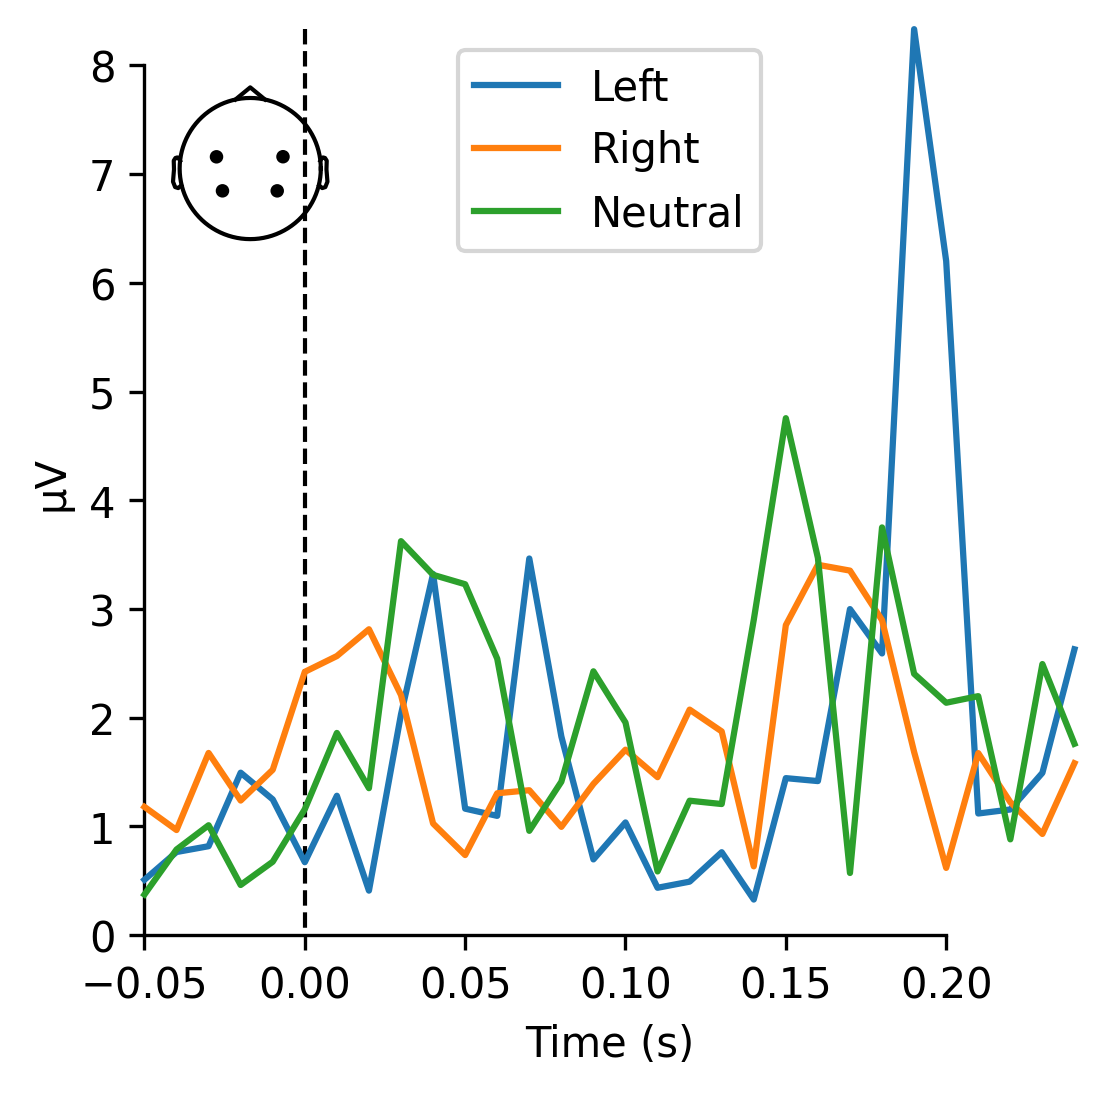

In [30]:
left_evoked = left_epochs.average()
right_evoked = right_epochs.average()
neutral_evoked = neutral_epochs.average()

pevkd = mne.viz.plot_compare_evokeds(dict(Left=left_evoked, Right=right_evoked, Neutral=neutral_evoked), legend='upper center', show_sensors='upper left', show = False)
pevkd = pevkd[0]
pevkd.set_figheight(4)
pevkd.set_figwidth(4)
pevkd.set_dpi(300)
pevkd.show()


No projector specified for this dataset. Please consider the method self.add_proj.


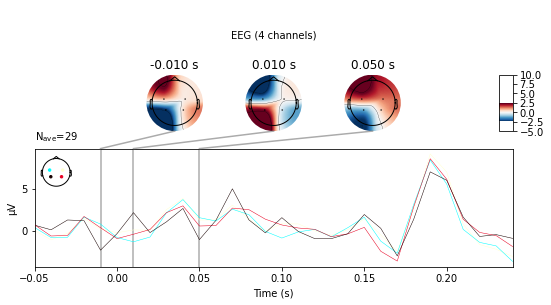

No projector specified for this dataset. Please consider the method self.add_proj.


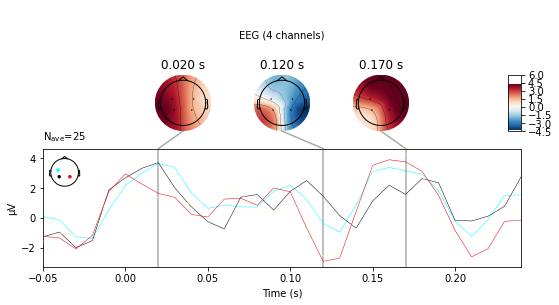

No projector specified for this dataset. Please consider the method self.add_proj.


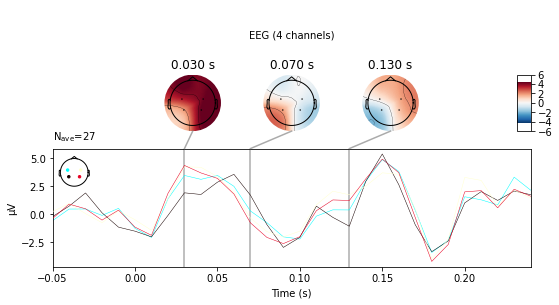

In [25]:
fp = left_evoked.plot_joint(picks = 'eeg', exclude = None)
fp = right_evoked.plot_joint(picks = 'eeg', exclude = None)
fp = neutral_evoked.plot_joint(picks = 'eeg', exclude = None)